In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import StratifiedKFold, train_test_split

from classification.datasets import Dataset
from classification.utils.audio_student import AudioUtil, Feature_vector_DS
from classification.utils.plots import (
    plot_decision_boundaries,
    plot_specgram,
    show_confusion_matrix,
)
from classification.utils.utils import accuracy

import tensorflow as tf
from keras import layers, models

dataset = Dataset()

fm_dir = "data/feature_matrices/"
model_dir = "data/models/"

nclass = dataset.nclass
naudio = dataset.naudio
classnames = dataset.list_classes()
num_classes = len(classnames)

Iteration:  0
seed =  1733162232
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6543 - loss: 1.0372
Test loss: 1.02742600440979
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


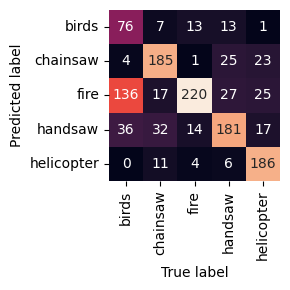

Test accuracy: 0.6730158925056458
birds: 12.32%
chainsaw: 20.90%
fire: 26.22%
handsaw: 24.58%
helicopter: 15.98%
Iteration:  1
seed =  1733162253


KeyboardInterrupt: 

In [3]:
for i in range(10):

    print("Iteration: ", i)

    np.random.seed(int(time.time()))

    print("seed = ", int(time.time()))

    myds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950, shift_pct=1.5, data_aug=['noise', 'echo', 'time_shift', 'scaling', 'pitch_shift', 'saturation'])

    feature_length = len(myds[classnames[0], 0])
    data_aug_factor = myds.data_aug_factor


    X_aug = np.zeros((data_aug_factor * nclass * naudio, 20, 20, 1))
    y_aug = np.zeros(data_aug_factor * nclass * naudio)

    for s in range(data_aug_factor):
        for idx in range(dataset.naudio):
            for class_idx, classname in enumerate(classnames):
                y_aug[s* nclass * naudio + class_idx * naudio + idx] = class_idx
                featvec = myds[classname, idx]
                X_aug[ s* nclass * naudio + class_idx * naudio + idx, :, :] = featvec.reshape(20, 20, 1)

    np.save(fm_dir + "feature_matrix_2D_aug.npy", X_aug)
    np.save(fm_dir + "labels_aug.npy", y_aug)

    X_aug = np.load(fm_dir + "feature_matrix_2D_aug.npy")
    y_aug = np.load(fm_dir + "labels_aug.npy")

    X_train, X_test, y_train, y_test = train_test_split(
        X_aug, y_aug, test_size=0.9, stratify=y_aug
    )
    
    """
    model = models.Sequential([
        layers.Input(shape=(20, 20, 1)),
        layers.Normalization(),
        layers.Conv2D(128, kernel_size=(4, 4), activation='leaky_relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.2),
        layers.Conv2D(256, kernel_size=(4, 4), activation='leaky_relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(256, activation='leaky_relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adamw',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    
    model.summary()
    """
    model = models.load_model(model_dir + "two.keras")
    
    ### change learining rate
    learning_rate = 0.1 * 10**(-np.log(i+1))
    
    optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    # history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), shuffle=True)

    # store the model

    model.save(model_dir + "two.keras", zipped=True)

    # evaluate the model

    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f'Test loss: {test_loss}')

    # plot the confusion matrix
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    show_confusion_matrix(y_pred_classes, y_test, classnames)
    print(f'Test accuracy: {test_acc}')

     #calculate the f1 score
    from sklearn.metrics import f1_score
    f1 = f1_score(y_test, y_pred_classes, average='weighted')

    # calculate the percentage for each class
    class_percentages = np.mean(y_pred, axis=0) * 100
    for classname, percentage in zip(classnames, class_percentages):
        print(f'{classname}: {percentage:.2f}%')